# Example 1: Single qubit dynamics

This first example will show some single qubit dynamics, and follow example 1. Let us begin by importing the requisite packages. You can run these locally by running ```pip install amazon-braket-sdk``` and ``` pip install quera-ahs-utils```. For more details, see https://github.com/aws/amazon-braket-sdk-python and https://github.com/QuEraComputing/quera-ahs-utils.

This notebook is not intended to reproduce every figure in the whitepaper. Instead, it is intended as an initial playground for you to generate your own experiments using QuEra's neutral atom quantum computer Aquila.

The notebook can be run on Amazon cloud, or locally. In order to run the code which interfaces with BraKet and Aquila, you must include your credentials in your environment. For details on this process, see this blog post https://aws.amazon.com/blogs/quantum-computing/setting-up-your-local-development-environment-in-amazon-braket/

In [73]:
from braket.aws import AwsQuantumTask
from braket.ahs.driving_field import DrivingField
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.aws import AwsDevice
from quera_ahs_utils.plotting import plot_task
import quera_ahs_utils.parallelize as pp

import quera_ahs_utils.drive as drive
import quera_ahs_utils.ir as ir

import numpy as np
import json, os

import matplotlib.pyplot as plt
from itertools import starmap
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = ["serif"]


#  There is a restriction on the rise and fall rate of the Rabi drive as imposed by hardware of 250 rad/usec/usec.
# Thus, the RAMP_TIME is the smallest possible amount of time to get to 15 rad/us.
RAMP_TIME = 0.06e-6
MIN_TIME_STEP = 0.05e-6 # The minimum time allowed between each point in the waveform, which is 50nsec

def batch_submit(qpu: AwsDevice, ahs_programs: list, json_output_filename: str, shots: int=100):
    """
    Submits a batch of jobs to AWS BraKet, and save associated data to file.
    """
    
    def submit_and_report(qpu: AwsDevice, ahs_program: AnalogHamiltonianSimulation, metadata):
        discretize_ahs_program = ahs_program.discretize(qpu)
        task = qpu.run(discretize_ahs_program, shots=shots)
        ahs_ir = discretize_ahs_program.to_ir()
        arn = task._arn
        task_bundle = {
            "task":eval(ahs_ir.json()),
            "metadata":str(metadata) # use eval to free data. 
        }
    
        return arn,task_bundle
    
    if not os.path.isfile(json_output_filename): # prevent accidental resubmission. 
        tasks = {}
        for ahs_program,*metadata in ahs_programs:
            try:
                arn, task_bundle = submit_and_report(qpu, ahs_program, metadata)
                tasks[arn] = task_bundle
            except BaseException as e: 
                print(ahs_program.to_ir().json(
                    indent=2,
                ))
                for arn in tasks:
                    AwsQuantumTask(arn).cancel()
                raise e
            
        with open(json_output_filename,"w") as IO:
            json.dump(tasks,IO,indent=2)
    else:
        raise RuntimeError("resubmitting jobs not allowed, please use different filename.")

## Example 1a: Rabi Oscillations
The first example is Rabi oscillations. Here, the Rabi drive is turned on for some variable time and the average Rydberg state probability is collected.

Observe that the Rabi frequency must start and end at zero, and so one must program in a rise and fall from zero as a trapezoid shape.

In [3]:
def rabi_ahs_program(run_time: float, rabi_value: float, detuning_value: float) -> AnalogHamiltonianSimulation:
    """
    Define a Rabi drive program
    run_time -       Total time of the pulse
    rabi_value -     Maximum Rabi amplitude
    detuning_value - A constant detuning
    """
    times = [0, RAMP_TIME, run_time + RAMP_TIME, run_time + 2 * RAMP_TIME] # Times for the picewise linear waveforms
    amplitude_values = [0, rabi_value, rabi_value, 0]                      # Rabi frequencies at each step
    detuning_values = [0, detuning_value, detuning_value, 0]               # Detunings at each step
    phase_values = [0, 0, 0, 0]                                            # Phase at each step. Phase is piecewise constant.
    
    global_drive = drive.get_drive(times, amplitude_values, detuning_values, phase_values)
    register = AtomArrangement()
    register.add((0,0))
    return AnalogHamiltonianSimulation(register, global_drive)

rabi_detuning_value = 0.0 # resonant rabi oscillations. 

# Set a range of times to simulate
rabi_run_times = np.around(np.arange(0,21,1) * 0.05e-6, 13)
# Define a set of AHS programs to run for each time
rabi_ahs_programs = [(rabi_ahs_program(run_time, 15e6, rabi_detuning_value), run_time) for run_time in rabi_run_times]

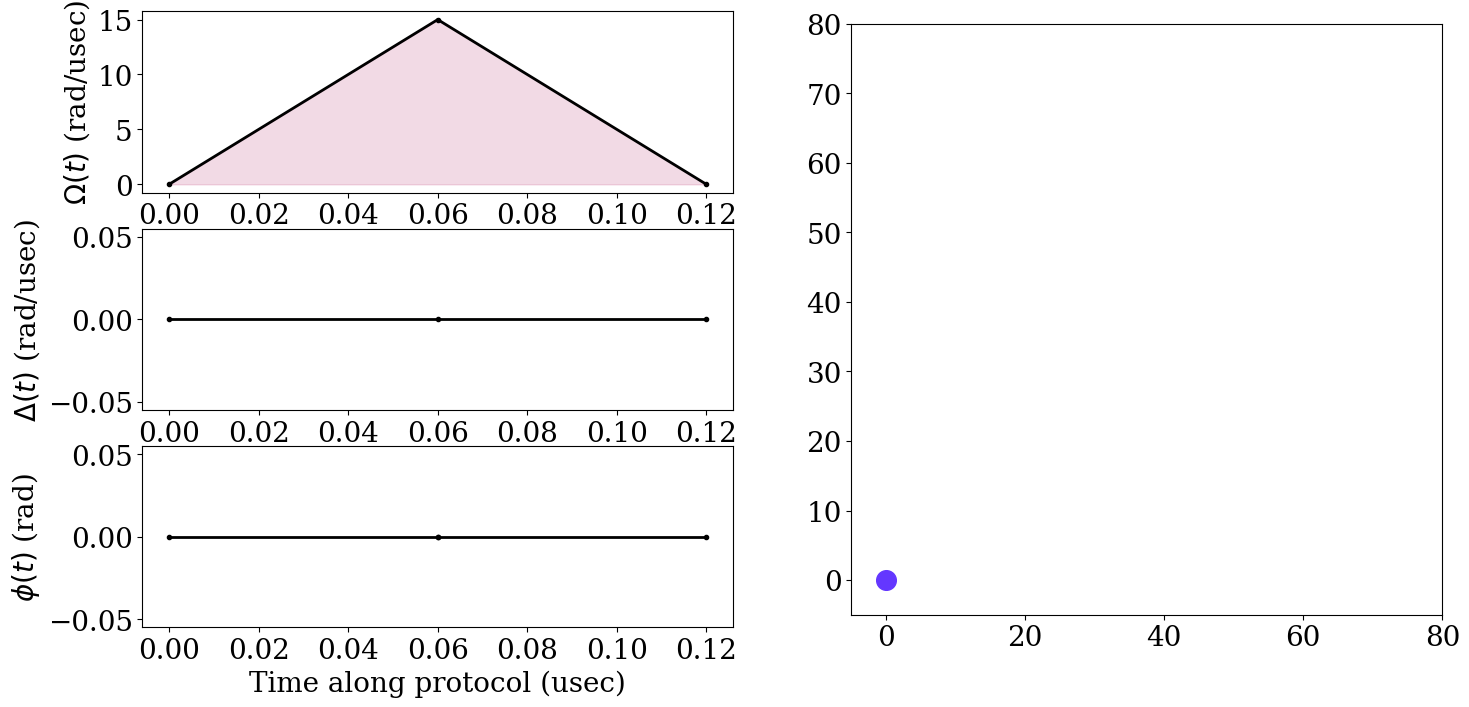

In [4]:
# Plot the task
program, run_time = rabi_ahs_programs[0]
plot_task(program,show_register=True)

Next, simulate the single atom tasks using a classical emulator.

In [5]:
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

rabi_sim_tasks = [(sim.run(ahs_program,shots=10000), None, run_time) for ahs_program,run_time in rabi_ahs_programs]

These same tasks can be sent to QuEra's hardware Aquila. However, it is wasteful to implement dynamics on only a single atom when the device can have many atoms. Instead, we parallelize the task by _multiplexing_ across the array. We duplicate each atom many times a "safe" distance away ($\geq 25.0 \mu\mathrm{m}$ ) so that each atom evolves independently. In this way, we require a factor of 16 fewer samples to accumulate adequate statistics.

This process is done using the ```quera_ahs_utils.parallelize.parallelize_ahs``` function, which duplicates a small task many times across the array, and returns a new task. Collecting the shot results can be done with a complementary function and the information is stored as metadata in each program.

In [6]:
qpu = AwsDevice(arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
    
parallel_rabi_ahs_programs = [pp.parallelize_ahs(ahs_program,qpu,24e-6)+(run_time,) for ahs_program,run_time in rabi_ahs_programs]

Finally, we can submit the tasks using the ```batch_submit``` function!

In [7]:
#raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, parallel_rabi_ahs_programs, "rabi_tasks.json", shots=100)

The ```batch_submit``` function saves the task ARN of each run, which can be loaded from Amazon BraKet. It will take some time between job submission and job completion. There is a queue which is usually quite full, and tasks are implemented as the machine becomes available. Once the tasks are complete, they can be loaded as below. For more details on availability and if your tasks are complete, go to your BraKet dashboard on AWS.

In [12]:
from braket.aws import AwsQuantumTask
import json

rabi_qpu_tasks = []
with open("rabi_tasks.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping,run_time = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        rabi_qpu_tasks.append((task,batch_mapping,run_time))

Finally, we can analyze each shot by computing the Rydberg density. A measurement of 0 corresponds to the Rydberg state, and a measurement of 1 corresponds to the ground state.

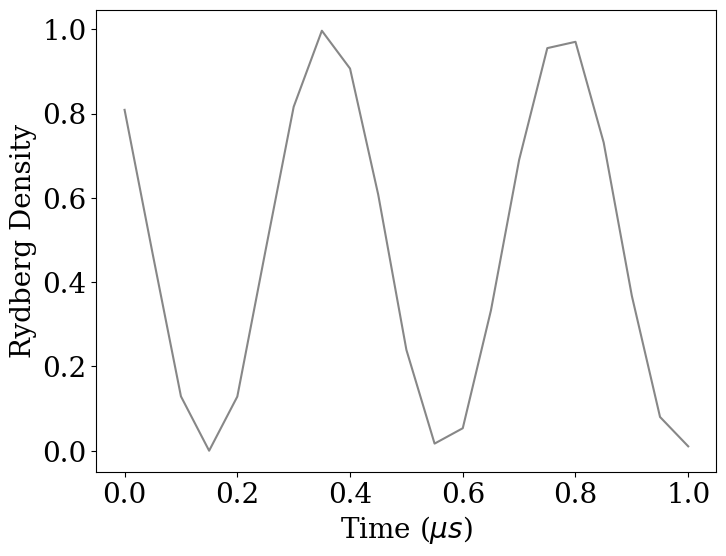

In [12]:
def get_densities(task,batch_mapping,run_time):
    shots = pp.get_shots_braket_sdk_results(task.result(),batch_mapping=batch_mapping,post_select=False)
    return run_time/1e-6,shots.mean(axis=0)

""" # Uncomment to compute QPU densities
rabi_qpu_results = list(starmap(get_densities,rabi_qpu_tasks))
rabi_qpu_results = sorted(rabi_qpu_results,key=lambda x:x[0])
rabi_run_times,rabi_qpu_density = zip(*rabi_qpu_results)
qpu_density = np.array(rabi_qpu_density)
"""

rabi_sim_results = list(starmap(get_densities,rabi_sim_tasks))
rabi_sim_results = sorted(rabi_sim_results,key=lambda x:x[0])
rabi_run_times,rabi_sim_density = zip(*rabi_sim_results)
sim_density = np.array(rabi_sim_density)

# A QuEra Colorscheme
RED    = "#C2477F"
PURPLE = "#6437FF"
YELLOW = "#edff1a"
YELLOW2= "#a8b512"
GREEN  = "#55de79"
BLACK  = "#878787"

plt.figure(figsize=(8,6))
plt.plot(rabi_run_times,rabi_sim_density,color=BLACK)
#plt.plot(rabi_run_times,rabi_qpu_density,color=PURPLE,linewidth=4) # Uncomment to plot QPU data


plt.ylabel("Rydberg Density")
plt.xlabel("Time ($\mu s$)")
plt.savefig("rabi_oscillation.svg")

# Example 1b. Ramsey Protocol

Next, we execute a Ramsey sequence, which is characterized by a sequence of 1) a pi/2 pulse to flip the state to a superposition $|0\rangle + |r\rangle$ state, 2) holding for some time with no drive to accumulate some phase from the environment, and 3) a -pi/2 pulse to flip the state back to the $|0\rangle$ state. This sequence is a sensitive probe to dephasing error of the qubits.

In [8]:
def ramsey_ahs_program(t_run: float, detuning_value: float) -> AnalogHamiltonianSimulation:
    """
    Define a Ramsey drive program.
    t_run          - Total evolution time, excluding the pi/2 rotation.
    detuning_value - Detuning offset, which drives sinusoidal oscillations
    """
    plateau_time = ((np.pi/2 - 0.625)/12.5) * 1e-6
    pi_over_two_pulse = drive.time_series(
        times = [0.0, 0.05e-6, plateau_time + 0.05e-6, 2*0.05e-6 + plateau_time],
        values = [0.0, 12.5e6, 12.5e6, 0.0]
    )
    
    detuning = drive.time_series([0,pi_over_two_pulse.times()[-1]],[detuning_value,detuning_value])
    phase = drive.time_series([0,pi_over_two_pulse.times()[-1]],[0,0])
    
    pi_over_two_drive = DrivingField(
        amplitude=pi_over_two_pulse,
        detuning=detuning,
        phase=phase
    )
    
    middle_drive = DrivingField(
        amplitude=drive.time_series([0,t_run],[0, 0]),
        detuning=drive.time_series([0,t_run],[detuning_value, detuning_value]),
        phase=drive.time_series([0,t_run],[0, 0])
    )
    
    global_drive = drive.concatenate_drive_list([pi_over_two_drive,middle_drive,pi_over_two_drive])
    register = AtomArrangement()
    register.add((0,0))
    return AnalogHamiltonianSimulation(register, global_drive)


ramsey_detuning_value = 10.5e6 # constant 10.5 rad/us

ramsey_run_times = np.around(np.arange(0,30,1) * 0.1e-6, 13) # sweep run time, but the Ramsey example goes for up to 3.5 microseconds
# for Rabi Pulse: go from 0 * 0.05e-6 to 21 * 0.05e-6 with step of 1 inbetween, then round to 13 decimals

ramsey_ahs_programs = [(ramsey_ahs_program(run_time, ramsey_detuning_value), run_time) for run_time in ramsey_run_times]

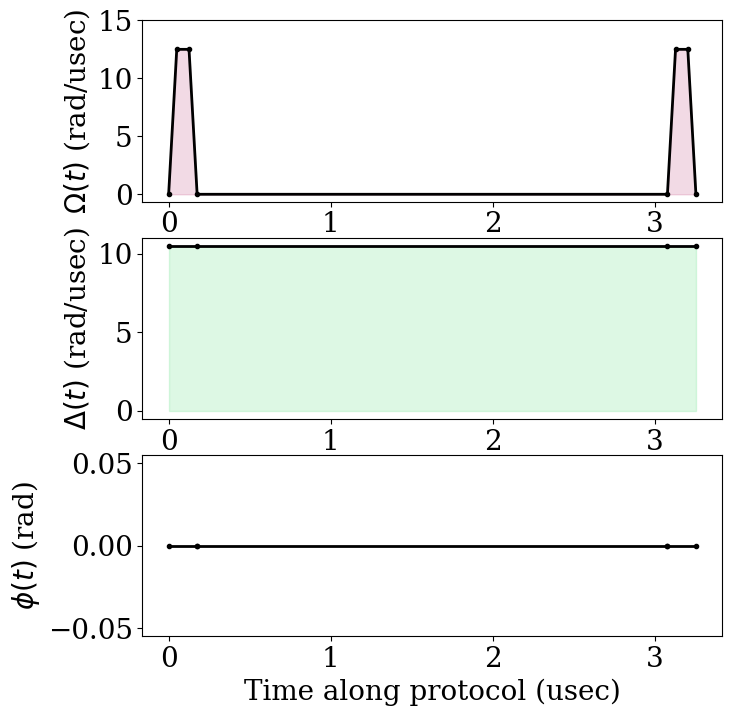

In [9]:
program, run_time = ramsey_ahs_programs[-1]
plot_task(program)

In [10]:
# Simulate each task
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

ramsey_sim_tasks = [(sim.run(ahs_program,shots=10000), None, run_time) for ahs_program,run_time in ramsey_ahs_programs]

In [11]:
# Multiplex
import quera_ahs_utils.parallelize as pp

qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila"
)
    
parallel_ramsey_ahs_programs = [pp.parallelize_ahs(ahs_program,qpu,24e-6)+(run_time,) for ahs_program,run_time in ramsey_ahs_programs]


In [12]:
# Submit to Aquila
# raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, parallel_ramsey_ahs_programs, "ramsey_tasks.json", shots=100)

In [11]:
# Load data from AHS once they are complete.
from braket.aws import AwsQuantumTask
import json

ramsey_qpu_tasks = []
with open("ramsey_tasks.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping,run_time = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        ramsey_qpu_tasks.append((task,batch_mapping,run_time))

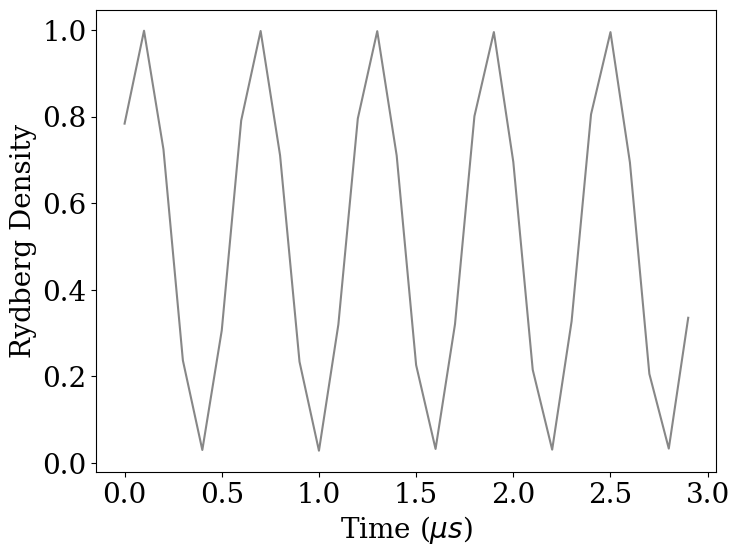

In [19]:
def get_densities(task,batch_mapping,run_time):
    shots = pp.get_shots_braket_sdk_results(task.result(),batch_mapping=batch_mapping,post_select=False)
    
    return run_time/1e-6,shots.mean(axis=0)

""" # Uncomment to compute QPU densities
ramsey_qpu_results = list(starmap(get_densities,ramsey_qpu_tasks))
ramsey_qpu_results = sorted(ramsey_qpu_results,key=lambda x:x[0])
ramsey_run_times,ramsey_qpu_density = zip(*ramsey_qpu_results)
ramsey_qpu_density = np.array(ramsey_qpu_density)
"""

ramsey_sim_results = list(starmap(get_densities,ramsey_sim_tasks))
ramsey_sim_results = sorted(ramsey_sim_results,key=lambda x:x[0])
ramsey_run_times,ramsey_sim_density = zip(*ramsey_sim_results)
ramsey_sim_density = np.array(ramsey_sim_density)


# QuEra color scheme
RED = "#C2477F"
PURPLE = "#6437FF"
YELLOW = "#edff1a"
YELLOW2= "#a8b512"
GREEN  = "#55de79"
BLACK  = "#878787"

plt.figure(figsize=(8,6))
plt.plot(ramsey_run_times,ramsey_sim_density,color=BLACK)
#plt.plot(ramsey_run_times,ramsey_qpu_density,color=PURPLE,linewidth=4) # Uncomment to plot QPU data


plt.ylabel("Rydberg Density")
plt.xlabel("Time ($\mu s$)")
plt.savefig("ramsey_protocol.svg")

# Example 1c. Floquet Protocol

In [79]:
MIN_TIME_STEP = 0.05e-6

def floquet_ahs_program(
        t_run: float,
        drive_frequency: float = 15e6, 
        drive_amplitude: float = 15e6, 
        rabi_max: float = 15.0e6,        
    ) -> AnalogHamiltonianSimulation:
    """
    t_run           - Total evolution time
    drive_frequency - Frequency of the sinusoidal drive of the detuning
    drive_amplitude - Detuning maximum amplitude
    """
    
    # Rabi Frequency

    total_time = t_run + 2*RAMP_TIME
    total_time = np.around(total_time, 13)
    amplitude = drive.time_series(
        [0,RAMP_TIME,t_run+RAMP_TIME,total_time],
        [0,rabi_max,rabi_max,0]
    )

    # Detuning 
    # times = np.arange(0,total_time - MIN_TIME_STEP, MIN_TIME_STEP)
    # times = np.hstack((times, [total_time]))
    # times = np.around(times, 13)
    time = 0
    times = []
    time_step = 0.06e-6
    while time < total_time - time_step:
        times.append(time)
        time += time_step
    times.append(total_time)
    times = np.around(times, 13)
    dt = np.diff(times)
    if np.any(dt < MIN_TIME_STEP):
        mask = dt < MIN_TIME_STEP
        print(dt[mask])
        

    values = drive_amplitude * np.sin(drive_frequency * times)
    detuning = drive.time_series(times,values)

    global_drive = DrivingField(
        amplitude=amplitude,
        detuning=detuning,
        phase=drive.time_series([0,total_time],[0, 0]) # phase
    )

    register = AtomArrangement()
    register.add((0,0))
    return AnalogHamiltonianSimulation(register, global_drive)



floquet_run_times = np.around(np.linspace(0,3e-6,101), 13) # sweep run time, but the Ramsey example goes for up to 3.5 microseconds
floquet_valid_times = floquet_run_times >= MIN_TIME_STEP
floquet_run_times = floquet_run_times[floquet_valid_times]
# for Rabi Pulse: go from 0 * 0.05e-6 to 21 * 0.05e-6 with step of 1 inbetween, then round to 13 decimals

floquet_ahs_programs = [(floquet_ahs_program(run_time), run_time) for run_time in floquet_run_times]

In [80]:
floquet_run_times

array([6.00e-08, 9.00e-08, 1.20e-07, 1.50e-07, 1.80e-07, 2.10e-07,
       2.40e-07, 2.70e-07, 3.00e-07, 3.30e-07, 3.60e-07, 3.90e-07,
       4.20e-07, 4.50e-07, 4.80e-07, 5.10e-07, 5.40e-07, 5.70e-07,
       6.00e-07, 6.30e-07, 6.60e-07, 6.90e-07, 7.20e-07, 7.50e-07,
       7.80e-07, 8.10e-07, 8.40e-07, 8.70e-07, 9.00e-07, 9.30e-07,
       9.60e-07, 9.90e-07, 1.02e-06, 1.05e-06, 1.08e-06, 1.11e-06,
       1.14e-06, 1.17e-06, 1.20e-06, 1.23e-06, 1.26e-06, 1.29e-06,
       1.32e-06, 1.35e-06, 1.38e-06, 1.41e-06, 1.44e-06, 1.47e-06,
       1.50e-06, 1.53e-06, 1.56e-06, 1.59e-06, 1.62e-06, 1.65e-06,
       1.68e-06, 1.71e-06, 1.74e-06, 1.77e-06, 1.80e-06, 1.83e-06,
       1.86e-06, 1.89e-06, 1.92e-06, 1.95e-06, 1.98e-06, 2.01e-06,
       2.04e-06, 2.07e-06, 2.10e-06, 2.13e-06, 2.16e-06, 2.19e-06,
       2.22e-06, 2.25e-06, 2.28e-06, 2.31e-06, 2.34e-06, 2.37e-06,
       2.40e-06, 2.43e-06, 2.46e-06, 2.49e-06, 2.52e-06, 2.55e-06,
       2.58e-06, 2.61e-06, 2.64e-06, 2.67e-06, 2.70e-06, 2.73e

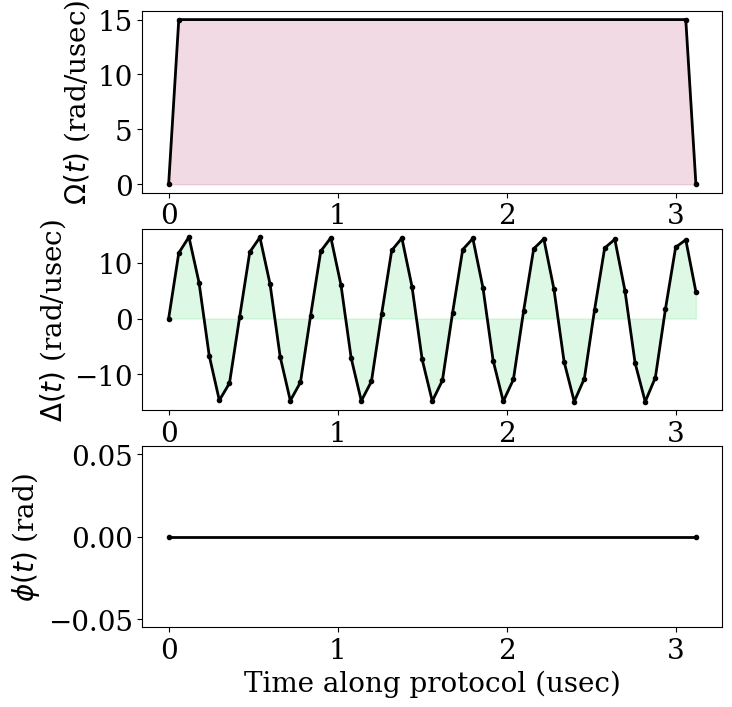

In [81]:
program, run_time = floquet_ahs_programs[-1]
plot_task(program)

In [82]:
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

# floquet_sim_tasks = [(sim.run(ahs_program,shots=10000), None, run_time) for ahs_program, run_time in floquet_ahs_programs]
for idx, (ahs_program, run_time) in enumerate(floquet_ahs_programs):
    task = sim.run(ahs_program, shots=10000)
    print(idx)

0
1
2
3
4
5
6


KeyboardInterrupt: 

In [83]:
import quera_ahs_utils.parallelize as pp

qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila"
)
    
parallel_floquet_ahs_programs = [pp.parallelize_ahs(ahs_program,qpu,24e-6)+(run_time,) for ahs_program,run_time in floquet_ahs_programs]

In [84]:
# Submit to Aquila
# raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, parallel_floquet_ahs_programs, "floquet_tasks.json", shots=50)

In [39]:
from braket.aws import AwsQuantumTask
import json

floquet_qpu_tasks = []
with open("floquet_tasks.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping,run_time = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        floquet_qpu_tasks.append((task,batch_mapping,run_time))

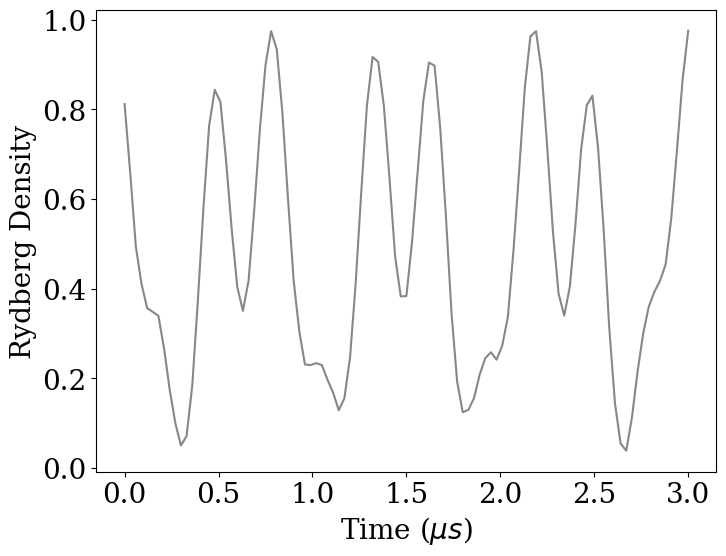

In [52]:
def get_densities(task,batch_mapping,run_time):
    shots = pp.get_shots_braket_sdk_results(task.result(),batch_mapping=batch_mapping,post_select=False)
    
    return run_time/1e-6,shots.mean(axis=0)

""" # Uncomment to compute QPU densities
floquet_qpu_results = list(starmap(get_densities,floquet_qpu_tasks))
floquet_qpu_results = sorted(floquet_qpu_results,key=lambda x:x[0])
floquet_run_times,floquet_qpu_density = zip(*floquet_qpu_results)
floquet_qpu_density = np.array(floquet_qpu_density)
"""

floquet_sim_results = list(starmap(get_densities,floquet_sim_tasks))
floquet_sim_results = sorted(floquet_sim_results,key=lambda x:x[0])
floquet_run_times,floquet_sim_density = zip(*floquet_sim_results)
floquet_sim_density = np.array(floquet_sim_density)


# QuEra colorscheme
RED = "#C2477F"
PURPLE = "#6437FF"
YELLOW = "#edff1a"
YELLOW2= "#a8b512"
GREEN  = "#55de79"
BLACK  = "#878787"

plt.figure(figsize=(8,6))
plt.plot(floquet_run_times,floquet_sim_density,color=BLACK)
#plt.plot(floquet_run_times,floquet_qpu_density,color=PURPLE,linewidth=4) # Uncomment to plot QPU results


plt.ylabel("Rydberg Density")
plt.xlabel("Time ($\mu s$)")
plt.savefig("floquet_protocol.svg")
